Let's try out the convex hull traveling salesperson code

In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
%matplotlib inline
import matplotlib.pylab as plt

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
def plot_route(towns, route):
    plt.scatter(towns[:,0], towns[:,1])
    plt.plot(towns[:,0][route], towns[:,1][route], 'k-')
    # plot the close
    plt.plot(towns[:,0][route][[-1,0]], towns[:,1][route][[-1,0]], 'k-')

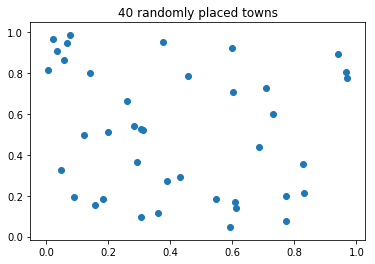

In [3]:
np.random.seed(42)
npts = 40
towns = np.random.rand(npts*2).reshape(npts,2)

dist_matrix = fs.generate_dist_matrix(towns)

plt.scatter(towns[:,0], towns[:,1])
plt.title('%i randomly placed towns' % npts)

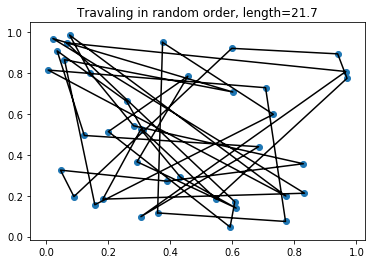

In [4]:
plot_route(towns, np.arange(npts))
d_orig = fs.route_length(range(npts), dist_matrix)
plt.title('Travaling in random order, length=%.1f' % d_orig)

In [5]:
hull_verts = fs.generate_hulls(towns)

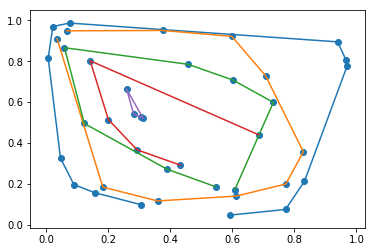

In [6]:
plt.scatter(towns[:,0], towns[:,1])
for indices in hull_verts:
    plt.plot(towns[:,0][indices], towns[:,1][indices])

In [7]:
merged = fs.merge_hulls(hull_verts, dist_matrix)

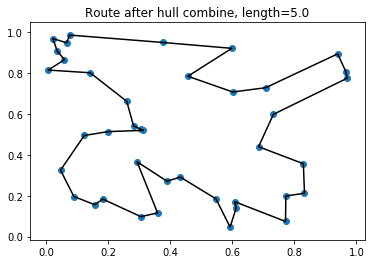

In [8]:
plot_route(towns, merged)
d_hull = fs.route_length(merged, dist_matrix)
plt.title('Route after hull combine, length=%.1f' % d_hull)

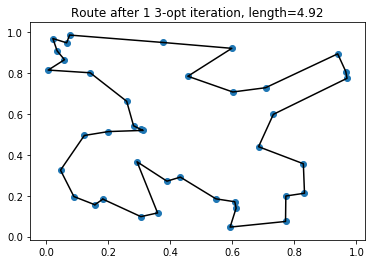

In [9]:
new_route, new_dist = fs.three_opt(merged, dist_matrix)
plot_route(towns, new_route)
plt.title('Route after 1 3-opt iteration, length=%.2f' % new_dist)

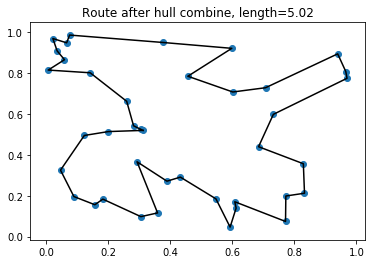

In [10]:
# Let's check that the wrapper function works
route_hull =  fs.tsp_convex(towns, optimize=False)
plot_route(towns, route_hull)
dist = fs.route_length(route_hull, dist_matrix)
plt.title('Route after hull combine, length=%.2f' % dist)

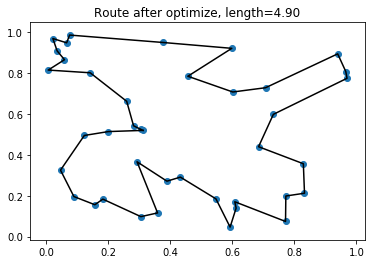

In [11]:
route_opt = fs.tsp_convex(towns, optimize=True)
plot_route(towns, route_hull)
dist = fs.route_length(route_opt, dist_matrix)
plt.title('Route after optimize, length=%.2f' % dist)

In [12]:
# Now to try it on some potential pointings
fields = fs.read_fields()

In [13]:
# Let's convert to alt,az, and select a blob near alt=65, az=180.
from lsst.sims.utils import Site
site = Site(name='LSST')
mjd = -1
alt, az = fs.stupidFast_RaDec2AltAz(fields['RA'], fields['dec'], site.latitude_rad, site.longitude_rad, mjd, lmst=0.)
dist = fs.haversine(np.pi, np.radians(65.), az, alt)
good = np.where(np.degrees(dist) < 15.)
alt = alt[good]
az = az[good]


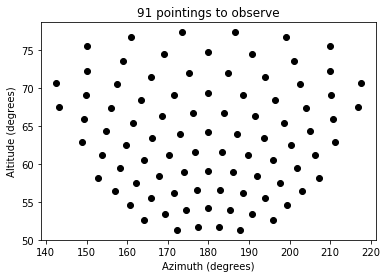

In [14]:
plt.plot(np.degrees(az), np.degrees(alt), 'ko')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Altitude (degrees)')
plt.title('%i pointings to observe' % alt.size)

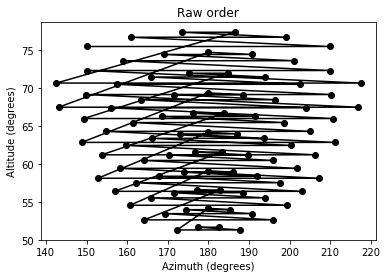

In [15]:
# If we just went by whatever order they happened to be in:
plt.plot(np.degrees(az), np.degrees(alt), 'k-')
plt.plot(np.degrees(az), np.degrees(alt), 'ko')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Altitude (degrees)')
plt.title('Raw order')

In [16]:
# Let's find a good spot to project the points to a plane
mid_alt = (np.max(alt) - np.min(alt))/2.

# Code snippet from MAF for computing mean of angle accounting for wrap around
x = np.cos(az)
y = np.sin(az)
meanx = np.mean(x)
meany = np.mean(y)
angle = np.arctan2(meany, meanx)
radius = np.sqrt(meanx**2 + meany**2)
mid_az = angle % (2.*np.pi)
if radius < 0.1:
    mid_az = np.pi
pointing_x, pointing_y = fs.gnomonic_project_toxy(az, alt, mid_az, mid_alt)

In [17]:
towns = np.vstack((pointing_x, pointing_y)).T
better_order = fs.tsp_convex(towns, optimize=False)

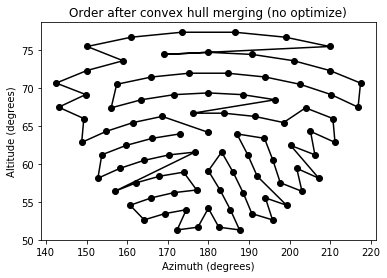

In [18]:
plt.plot(np.degrees(az)[better_order], np.degrees(alt)[better_order], 'k-')
plt.plot(np.degrees(az)[better_order], np.degrees(alt)[better_order], 'ko')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Altitude (degrees)')
plt.title('Order after convex hull merging (no optimize)')

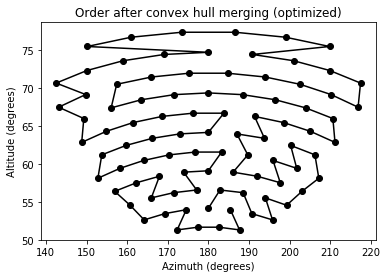

In [19]:
# try it with optimization turned on. This gets a bit slooooowwwwww.
better_order = fs.tsp_convex(towns, optimize=True)

plt.plot(np.degrees(az)[better_order], np.degrees(alt)[better_order], 'k-')
plt.plot(np.degrees(az)[better_order], np.degrees(alt)[better_order], 'ko')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Altitude (degrees)')
plt.title('Order after convex hull merging (optimized)')